In [ ]:
#This code computes medians of errors and uses bootstrapping to calculate errors of medians

In [36]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.gridspec as gridspec
import ast
import sys
sys.path.append('machine-scientist/')
sys.path.append('machine-scientist/Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import bootstrap

In [37]:
#Get and sort errors of interpolation
def get_errors(resolution='1x'):
    #read errors
    errors_interpolation=pd.read_csv('../data/'+ 'all_errors_interpolation' +  '.csv',index_col=0)
    columns=["sigma", "function","rmse_nn_interp.", "rmse_nn_extrap.", "rmse_mdl_interp.", "rmse_mdl_extrap.", "n", "r"]
    errors_interpolation=errors_interpolation[columns]
    display(errors_interpolation)

    #divide between train/test
    errors_interpolation_train=errors_interpolation[["sigma","function", "rmse_nn_interp.", "rmse_mdl_interp.","n", "r"]]
    errors_interpolation_train=pd.melt(errors_interpolation_train,id_vars=["sigma","function", "n", "r"], var_name="error_interp.",value_name= "value_interp.")   

    errors_interpolation_test=errors_interpolation[["sigma","function", "rmse_nn_extrap.", "rmse_mdl_extrap.","n", "r"]]
    errors_interpolation_test=pd.melt(errors_interpolation_test,id_vars= ["sigma","function", "n", "r"], var_name="error_extrap.", value_name= "value_extrap.")

    #Separate tanh and leaky ReLU
    errors_t_tr=errors_interpolation_train[errors_interpolation_train['function']=='tanh']
    errors_t_tt=errors_interpolation_test[errors_interpolation_test['function']=='tanh']

    errors_l_tr=errors_interpolation_train[errors_interpolation_train['function']=='leaky_ReLU']
    errors_l_tt=errors_interpolation_test[errors_interpolation_test['function']=='leaky_ReLU']

    return errors_t_tr, errors_t_tt, errors_l_tr, errors_l_tt

In [39]:
#Read errors and take rmse
resolution='1x' #0.5x, 1x, 2x, 4e-3x
errors_tanh_inter, errors_tanh_extra, errors_leaky_inter, errors_leaky_extra=get_errors()

,sigma,function,rmse_nn_interp.,rmse_nn_extrap.,rmse_mdl_interp.,rmse_mdl_extrap.,n,r
0,0.0,tanh,0.012386,0.060146,0.001340,0.011199,0,0
1,0.0,tanh,0.012122,0.026266,0.003454,0.454497,1,0
2,0.0,tanh,0.006643,0.085908,0.001222,0.069993,2,0
3,0.0,tanh,0.001461,0.089270,0.000406,0.048799,3,0
4,0.0,tanh,0.002459,0.014093,0.000248,0.003921,4,0
...,...,...,...,...,...,...,...,...
655,0.2,leaky_ReLU,0.087048,0.182138,0.010784,0.164822,5,2
656,0.2,leaky_ReLU,0.127071,0.610832,0.142086,0.234066,6,2
657,0.2,leaky_ReLU,0.105589,4.418359,0.041496,0.046699,7,2
658,0.2,leaky_ReLU,0.141243,3.278076,0.114628,0.176435,8,2


In [42]:
#Figure configuration
#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 8*cm; height=6*cm

Extensions=['.png', '.pdf']

#colors from seaborn's colorblind palette
color_data=sns.color_palette("colorblind")[0]
color_noise=sns.color_palette("colorblind")[7]
color_ann=sns.color_palette("colorblind")[4]
color_bms=sns.color_palette("colorblind")[2]

#Fonts and sizes                                                                                    
size_axis=12;size_ticks=10;size_title=5
line_w=1;marker_s=3 #width and marker size                                                          
m_size=6

output_path='../results/'

resamples=100000; bs_seed=1111 #number of resamples
ymin=2e-4;ymax=0.75

(array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
 [Text(0, 9.999999999999999e-06, '$\\mathdefault{10^{-5}}$'),
  Text(0, 9.999999999999999e-05, '$\\mathdefault{10^{-4}}$'),
  Text(0, 0.001, '$\\mathdefault{10^{-3}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 0.09999999999999999, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$')])

<Figure size 944.882x708.661 with 0 Axes>

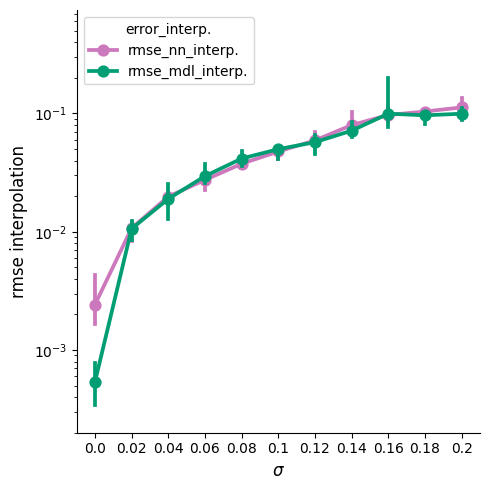

<Figure size 944.882x708.661 with 0 Axes>

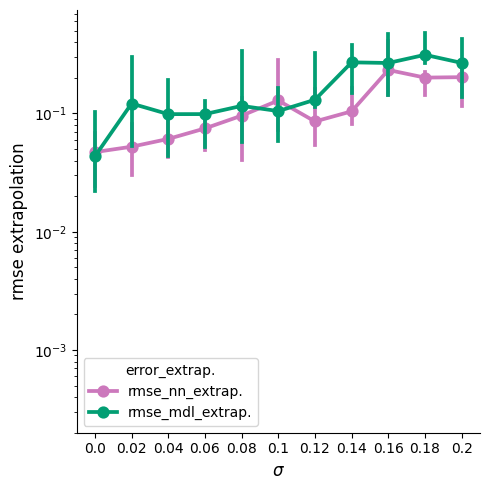

In [43]:
#Plot tanh interpolation
#----------------------------------------------------------------------------------------------------------------------
fig=figure(figsize=(width,height), dpi=300)
sns.catplot(data=errors_tanh_inter, x='sigma', y='value_interp.', hue='error_interp.', kind='point', estimator='median',
            errorbar=('ci', 95),n_boot=resamples, seed=bs_seed, palette=[color_ann, color_bms],legend_out=False)

plt.yscale("log")

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis);plt.ylabel('rmse interp',fontsize=size_axis)
plt.yscale("log")
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.ylim(ymin,ymax)

plt.tight_layout()

name_fig= 'interpolation_medians_tanh'
plt.savefig(output_path+name_fig + '.svg',dpi=300)
plt.savefig(output_path+name_fig + '.png',dpi=300)

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis) 
plt.ylabel('rmse interpolation',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
#----------------------------------------------------------------------------------------------------------------------

#Plot tanh extrapolation
#----------------------------------------------------------------------------------------------------------------------
fig=figure(figsize=(width,height), dpi=300)
sns.catplot(data=errors_tanh_extra, x='sigma', y='value_extrap.', hue='error_extrap.', kind='point', estimator='median',
            errorbar=('ci', 95),n_boot=resamples, seed=bs_seed, palette=[color_ann, color_bms],legend_out=False)

plt.yscale("log")

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis);plt.ylabel('rmse extrap',fontsize=size_axis)
plt.yscale("log")
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.ylim(ymin,ymax)

plt.tight_layout()

name_fig= 'extrapolation_medians_tanh'
plt.savefig(output_path+name_fig + '.svg',dpi=300)
plt.savefig(output_path+name_fig + '.png',dpi=300)

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis) 
plt.ylabel('rmse extrapolation',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
#----------------------------------------------------------------------------------------------------------------------

(0.0002, 0.75)

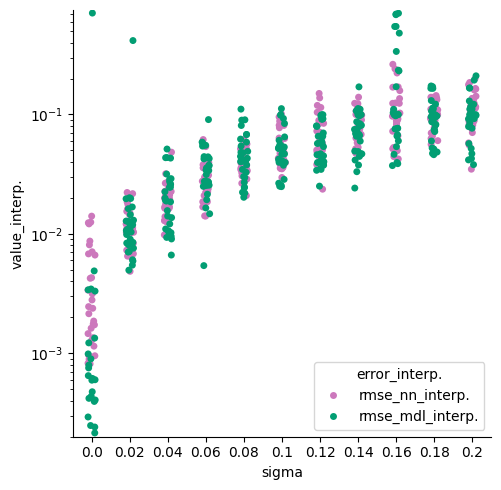

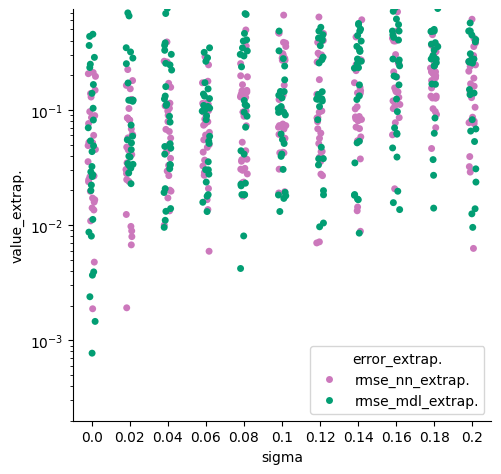

In [44]:
#Plot individual simulations
sns.catplot(data=errors_tanh_inter, x='sigma', y='value_interp.', hue='error_interp.',palette=[color_ann, color_bms],legend_out=False)
plt.yscale("log")
plt.ylim(ymin,ymax)

sns.catplot(data=errors_tanh_extra, x='sigma', y='value_extrap.', hue='error_extrap.',palette=[color_ann, color_bms],legend_out=False)
plt.yscale("log")
plt.ylim(ymin,ymax)

(array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
 [Text(0, 9.999999999999999e-06, '$\\mathdefault{10^{-5}}$'),
  Text(0, 9.999999999999999e-05, '$\\mathdefault{10^{-4}}$'),
  Text(0, 0.001, '$\\mathdefault{10^{-3}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 0.09999999999999999, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$')])

<Figure size 944.882x708.661 with 0 Axes>

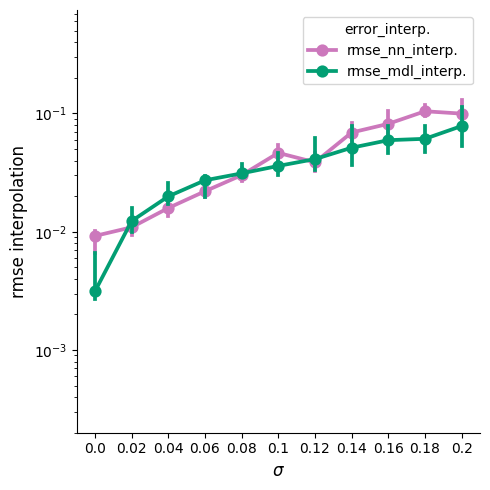

<Figure size 944.882x708.661 with 0 Axes>

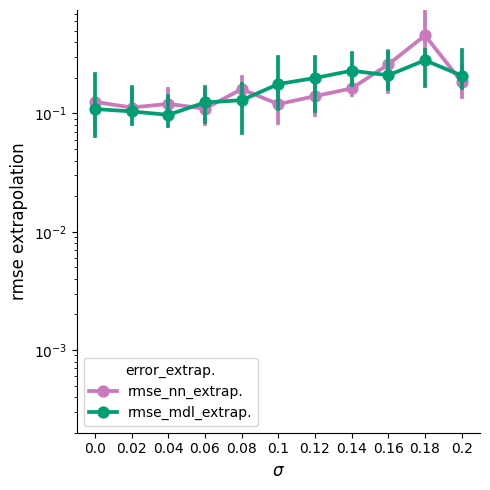

In [45]:
#Plot leaky interpolation
#----------------------------------------------------------------------------------------------------------------------
fig=figure(figsize=(width,height), dpi=300)
sns.catplot(data=errors_leaky_inter, x='sigma', y='value_interp.', hue='error_interp.', kind='point', estimator='median',
            errorbar=('ci', 95),n_boot=resamples, seed=bs_seed, palette=[color_ann, color_bms],legend_out=False)

plt.yscale("log")

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis);plt.ylabel('rmse interp',fontsize=size_axis)
plt.yscale("log")
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.ylim(ymin,ymax)

plt.tight_layout()

name_fig= 'interpolation_medians_leaky'
plt.savefig(output_path+name_fig + '.svg',dpi=300)
plt.savefig(output_path+name_fig + '.png',dpi=300)

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis) 
plt.ylabel('rmse interpolation',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
#----------------------------------------------------------------------------------------------------------------------

#Plot tanh extrapolation
#----------------------------------------------------------------------------------------------------------------------
fig=figure(figsize=(width,height), dpi=300)
sns.catplot(data=errors_leaky_extra, x='sigma', y='value_extrap.', hue='error_extrap.', kind='point', estimator='median',
            errorbar=('ci', 95),n_boot=resamples, seed=bs_seed, palette=[color_ann, color_bms],legend_out=False)

plt.yscale("log")

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis);plt.ylabel('rmse extrap',fontsize=size_axis)
plt.yscale("log")
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.ylim(ymin,ymax)

plt.tight_layout()

name_fig='extrapolation_medians_leaky'
plt.savefig(output_path+name_fig + '.svg',dpi=300)
plt.savefig(output_path+name_fig + '.png',dpi=300)

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis) 
plt.ylabel('rmse extrapolation',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
#----------------------------------------------------------------------------------------------------------------------

(0.0002, 0.75)

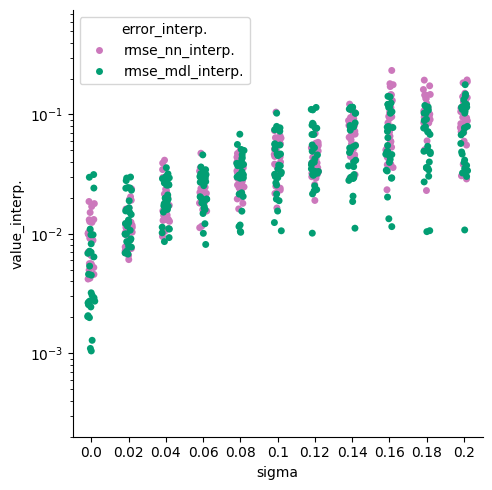

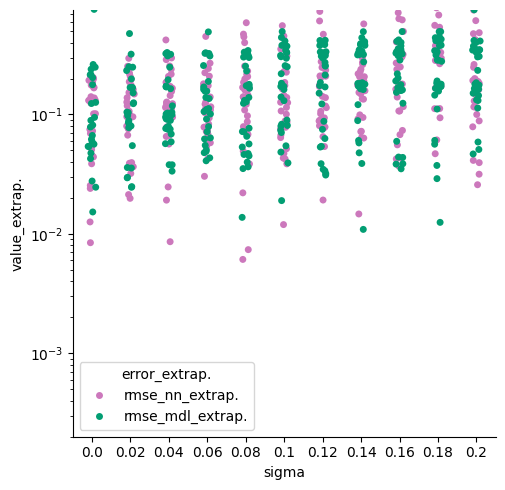

In [46]:
#Plot individual simulations leaky
sns.catplot(data=errors_leaky_inter, x='sigma', y='value_interp.', hue='error_interp.',palette=[color_ann, color_bms],legend_out=False)
plt.yscale("log")
plt.ylim(ymin,ymax)

sns.catplot(data=errors_leaky_extra, x='sigma', y='value_extrap.', hue='error_extrap.',palette=[color_ann, color_bms],legend_out=False)
plt.yscale("log")
plt.ylim(ymin,ymax)